<a href="https://colab.research.google.com/github/yurimmmmmm/project/blob/main/Roberta_classficiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Install using pip
!pip install transformers
!pip install gpytorch

In [ ]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import transformers
import json
import os
from tqdm import tqdm
import torch.nn.functional as F
import gpytorch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
%matplotlib inline
logging.basicConfig(level=logging.ERROR)

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
set_seed(42)
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
#############################################################
#Use below code to upload your kaggle.json to colab environment
#(you can download kaggle.json from your Profile->Account->API Token)
# 이 코드 실행하면, 밑에 파일 업로드하라고 되어 있을텐데,
# kaggle 가서  your Profile->Account->API Token에서 kaggle.json 다운 받아서 업로드 하면 됩니다
######################################################################3

from google.colab import files

files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d narayan63/netflix-popular-movies-dataset
!kaggle datasets download -d omkarborikar/top-10000-popular-movies

!unzip -q /content/netflix-popular-movies-dataset.zip
!unzip -q /content/top-10000-popular-movies.zip

Saving kaggle.json to kaggle.json
netflix-popular-movies-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
top-10000-popular-movies.zip: Skipping, found more recently modified local copy (use --force to force download)
replace n_movies.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Top_10000_Movies.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
train = pd.read_csv('/content/n_movies.csv', lineterminator='\n')
train1 = pd.read_csv('/content/Top_10000_Movies.csv', lineterminator='\n')

In [ ]:
#전처리
##############################################################
#위 두 데이터셋을 합치고, overview랑 rating만 남겨놓게 전처리 한겁니다.
#향후에 바꿀 겁니다
##############################################################3
duplicate = set(train['title'].values) & set(train1['original_title'].values)
for i in duplicate:
  train1 = train1[train1.original_title != i]
new_df = train[['rating', 'description', 'genre']]
new_df1 = train1[['vote_average', 'overview', 'genre']]
new_df1 = new_df1.rename(columns={"vote_average": "rating", "overview": "description"})
new_df = pd.concat([new_df, new_df1],ignore_index=True)
new_df = new_df[new_df.rating.notnull()]
new_df = new_df[new_df['rating']!= 0]
new_df = new_df[new_df.description != 'Add a Plot'] #description 란에 add a plot이란 text가 들어간 영화들이 있는데, 이 영화들은 빼준다
new_df = new_df[new_df.description != 'Nan']
new_df = new_df[new_df.description.notnull()]

In [ ]:
new_df

,rating,description,genre
0,8.5,Decades after their 1984 All Valley Karate Tou...,"Action, Comedy, Drama"
1,8.7,Follows the political rivalries and romance of...,"Biography, Drama, History"
2,8.9,The trials and tribulations of criminal lawyer...,"Crime, Drama"
3,5.9,When a psychiatrist shelters a mysterious cult...,"Drama, Horror, Mystery"
4,8.6,A Street Kid trying to survive in a technology...,"Animation, Action, Adventure"
...,...,...,...
18803,7.5,Wallace and Gromit have run out of cheese and ...,"['Adventure', 'Animation', 'Comedy', 'Science ..."
18804,7.0,"The rise and fall of salsa singer, Héctor Lavo...","['History', 'Drama', 'Music']"
18805,6.6,An American girl on holiday in the English cou...,"['Drama', 'Action', 'Thriller', 'War']"
18806,7.4,A vacuum repairman moonlights as a street musi...,"['Drama', 'Music', 'Romance']"


In [ ]:
##############################################
#prompt tuning으로 새로운 column 만들기
################################################
new_df['genre'] = 'this movie genre is' +' '+ new_df['genre']
new_df['description'] = 'this movie description is' +' '+ new_df['description']
new_df['new_input'] = new_df['description'] + ' ' + new_df['genre']

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 데이터 전처리를 마친 new_df 데이터프레임을 사용한다고 가정

# rating 데이터를 5개의 군으로 나누기
# 구간을 [0, 2), [2, 4), [4, 6), [6, 8), [8, 10]으로 나눔

bins = [0, 2, 4, 6, 8, 10]
labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
new_df['rating_group'] = pd.cut(new_df['rating'], bins=bins, labels=labels)

label_mapping = {'Very Low': 0, 'Low': 1, 'Moderate': 2, 'High': 3, 'Very High': 4}

new_df['rating_group_encoded'] = new_df['rating_group'].map(label_mapping)



In [ ]:
new_df

,rating,description,genre,new_input,rating_group,rating_group_encoded
0,8.5,this movie description is this movie descripti...,this movie genre is this movie genre is Action...,this movie description is this movie descripti...,Very High,4
1,8.7,this movie description is this movie descripti...,this movie genre is this movie genre is Biogra...,this movie description is this movie descripti...,Very High,4
2,8.9,this movie description is this movie descripti...,"this movie genre is this movie genre is Crime,...",this movie description is this movie descripti...,Very High,4
3,5.9,this movie description is this movie descripti...,"this movie genre is this movie genre is Drama,...",this movie description is this movie descripti...,Moderate,2
4,8.6,this movie description is this movie descripti...,this movie genre is this movie genre is Animat...,this movie description is this movie descripti...,Very High,4
...,...,...,...,...,...,...
18803,7.5,this movie description is this movie descripti...,this movie genre is this movie genre is ['Adve...,this movie description is this movie descripti...,High,3
18804,7.0,this movie description is this movie descripti...,this movie genre is this movie genre is ['Hist...,this movie description is this movie descripti...,High,3
18805,6.6,this movie description is this movie descripti...,this movie genre is this movie genre is ['Dram...,this movie description is this movie descripti...,High,3
18806,7.4,this movie description is this movie descripti...,this movie genre is this movie genre is ['Dram...,this movie description is this movie descripti...,High,3


import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(new_df, *['rating'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(new_df, *['rating'], **{})
chart

In [ ]:
new_df

In [ ]:
##########################################################
#model 학습 시 중간 중간 모델 weight를 저장해주는 function
##########################################################
from pathlib import Path

def save_ckpt(output_dir, model,likelihood, optimizer, epoch, filename):
    # save_ckpt: function for saving checkpoints
    output_dir = Path(output_dir)
    #saving ckpt for roberta
    if likelihood is None:
      if output_dir:
        checkpoint_path = output_dir / f'{filename}.pth'
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
        }, checkpoint_path)
    #saving ckpt for gp regression
    else:
      if output_dir:
        checkpoint_path = output_dir / f'{filename}.pth'
        torch.save({
            'model': model.state_dict(),
            'likelihood': likelihood.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
        }, checkpoint_path)


In [ ]:
# Defining some key variables that will be used later on in the training
# 학습 hyperparameter
MAX_LEN = 512
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 32
# EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [ ]:
class MovieData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.new_input   #### dataset에서 text input으로 쓰고 싶은 column명을 쓰면 됩니다
        self.targets = self.data.rating_group_encoded  #### dataset에서 우리의 target
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_size = 0.8
train_data=new_df.sample(frac=train_size,random_state=200)
test_data=new_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = MovieData(train_data, tokenizer, MAX_LEN)
testing_set = MovieData(test_data, tokenizer, MAX_LEN)

FULL Dataset: (17065, 6)
TRAIN Dataset: (13652, 6)
TEST Dataset: (3413, 6)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

1. Roberta로 예측

In [ ]:
class MLP(torch.nn.Module):
    """ Very simple multi-layer perceptron (also called FFN)"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = torch.nn.ModuleList(torch.nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x


class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        ##### Roberta의 핵심 부분 freeze시킨다
        for param in self.l1.parameters():
          param.requires_grad = False
        self.pre_classifier = MLP(768,768,768,3)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5) # 변경

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state.detach().mean(dim=1)
        pooler = self.pre_classifier(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        batch_size = data['targets'].shape[0]
        targets = torch.zeros((batch_size,5))
        for i in range(batch_size):
          targets[i][int(data['targets'][i])]=1
        targets = targets.to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)

        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        #big_val, big_idx = torch.max(outputs.data, dim=1)
        #n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        #nb_tr_examples+=targets.size(0)

        #if _%5000==0:
        #    loss_step = tr_loss/nb_tr_steps
        #    accu_step = (n_correct*100)/nb_tr_examples
        #    print(f"Training Loss per 5000 steps: {loss_step}")
        #    print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()
    #checkpoint 저장하기, 위에 save_ckpt 함수 참고하기
    print(epoch)
    save_ckpt('/content/gdrive/MyDrive/ML_final', model, None, optimizer, epoch = epoch, filename='checkpoint_roberta_classfication1')
    print(f'The Total CrossEntrophy loss for Epoch {epoch}: {tr_loss}')
    epoch_loss = tr_loss/nb_tr_steps
    #epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Average Training Loss Epoch: {epoch_loss}")
    #print(f"Training Accuracy Epoch: {epoch_accu}")

    return

In [ ]:
####################################################################################
#*미리 모델을 학습한경우, 모델 학습 checkpoint 경로를 복사해서 resume에 넣어두면 됨.
#*처음부터 다시 시작하고 싶은 경우 resume = False로 해두기
####################################################################################
EPOCHS = 20
resume = False #checkpoint pth file로의 경로를 넣어주시면 됩니다, 처음부터 학습하고 싶으면 resume = False
start_iter = 0
#creating model from robertaclass
model = RobertaClass()
model.to(device)
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss() #변경
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
if resume:
      checkpoint = torch.load(resume, map_location='cpu')
      model.load_state_dict(checkpoint['model'], strict = False)
      optimizer.load_state_dict(checkpoint['optimizer'])
      start_iter = checkpoint['epoch']
      print(start_iter)
for epoch in range(start_iter, EPOCHS):
    train(epoch)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
214it [07:28,  2.09s/it]


0
The Total MSE loss for Epoch 0: 249.08488297462463
Average Training Loss Epoch: 1.1639480512832927


In [ ]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0
    n_wrong = 0
    total = 0
    tr_loss = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    true_targets = list()
    true_outputs = list()

    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)

            batch_size = data['targets'].shape[0]
            targets = torch.zeros((batch_size,5))
            for i in range(batch_size):
              targets[i][int(data['targets'][i])]=1
            targets = targets.to(device, dtype=torch.float)

            true_targets.append(targets.cpu().numpy())
            outputs = model(ids, mask, token_type_ids).squeeze()
            true_outputs.append(outputs.cpu().numpy())

            loss = loss_function(outputs, targets)
            tr_loss += loss.item()

            # argmax를 사용하여 예측 클래스 인덱스 찾기
            predicted = torch.argmax(outputs, dim=0)

            # 정답과 예측을 비교하여 정확도 계산
            n_correct += (predicted == targets).sum().item()
            nb_tr_steps += 1
            nb_tr_examples += targets.size(0)

    epoch_loss = tr_loss / nb_tr_steps
    epoch_accu = (n_correct * 100) / nb_tr_examples
    print(true_targets, true_outputs)
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_loss, true_targets, true_outputs

In [ ]:
loss, true_targets, true_outputs = valid(model, testing_loader)
print("Average CrossEntrophy loss on test data = %0.2f" % loss)

[array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32), array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0

[4, 2, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 4, 3, 4, 3, 4, 4, 3, 3, 4, 3, 2, 2, 4, 2, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 2, 3, 3, 3, 3, 4, 4, 3, 4, 4, 2, 3, 3, 3, 4, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 4, 3, 2, 3, 2, 3, 2, 4, 4, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 4, 3, 2, 3, 4, 3, 2, 2, 3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 2, 4, 3, 2, 4, 3, 3, 3, 4, 3, 3, 3, 2, 2, 2, 3, 2, 3, 3, 3, 2, 4, 3, 2, 3, 2, 3, 3, 3, 4, 3, 3, 3, 2, 2, 3, 4, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 4, 4, 3, 3, 2, 3, 3, 4, 3, 3, 3, 2, 3, 2, 4, 3, 2, 3, 4, 3, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 2, 3, 3, 4, 3, 3, 2, 2, 3, 3, 4, 2, 3, 3, 3, 3, 2, 4, 2, 3, 4, 2, 3, 3, 3, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 2, 3, 3, 3, 4, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 4, 1, 4, 

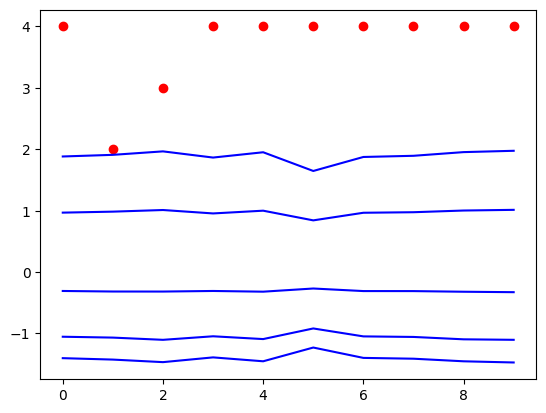

In [ ]:
target = [item for sublist in true_targets for item in sublist]
pred = [item for sublist in true_outputs for item in sublist]
#print(target, pred)
target_list = [np.argmax(target[i]) for i in range(len(target))]
print(target_list)
plt.scatter(range(10), target_list[:10], color = 'red')
plt.plot(range(10), pred[:10], color = 'blue')

def convert_to_pred(output) :
  pred = torch.zero(batch_size, 5)
  for i in range(batch_size) :
    pred[i][argmax(output[i])]=1
  return pred


In [ ]:
################with other inputs
target = [item for sublist in true_target for item in sublist]
pred = [item for sublist in true_output for item in sublist]
plt.scatter(range(100), target[:100], color = 'red')
plt.plot(range(100), pred[:100], color = 'blue')